- Student Name: Xiuwen (Alice) Zhu
- Student ID: 1149188
- Course Code: COMP647
- Course Examiner: Professor Don Kulasiri
- Due Date: 03/11/2025

# Project Plan

1.	Feature engineering and feature selection as appropriate to your dataset. Briefly explain and justify what you do using comments in your Python code. *(Feature engineering and feature selection was completed in assignment 2, so I will go straight to plan 2. )*

2.	Use appropriate machine learning algorithms (supervised and/or unsupervised) to perform forecasting, classification or clustering tasks with respect to your dataset. Justify why the respective algorithms are selected.
3.	Conduct performance measures in the algorithm evaluations and justify the selected the performance measures would be the most appropriate to evaluate the algorithms chosen. 
4.	Explain how you avoid over fitting and underfitting of the algorithms. 
5.	Perform appropriate eXplainable AI techniques to discover which features are influencing the predictions


# Research Questions

**As an entrepreneur, I want to know:**
Which sub-categories will have better sales based on their current sale, number of reviews and rating. 

**As a buyer, I want to know:**
Which sellers have received more consistent high ratings for their products?

**As the company, I want to know:**
What are the main factors of the sold products that may be contributing to the variation in sales?



# Import the Neccessary Libaries for Machine Learning

In [112]:
import itertools
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns    
import hdbscan  
import os
from scipy.spatial.distance import cdist         
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest



# Read Data from CSV

In [74]:
file_path = 'cleaned_amazon_ecommerce.csv' # Define the file path for the dataset.
df = pd.read_csv (file_path)

# View Data

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9983 entries, 0 to 9982
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   uniq_id                         9983 non-null   object 
 1   product_name                    9983 non-null   object 
 2   number_of_reviews               9983 non-null   int64  
 3   cleaned_price                   9983 non-null   float64
 4   stock_quantity                  9983 non-null   int64  
 5   stock_condition                 9983 non-null   object 
 6   average_review_rating_out_of_5  9983 non-null   float64
 7   main_category                   9983 non-null   object 
 8   sub_category                    9983 non-null   object 
 9   item_weight_in_kg               9983 non-null   float64
 10  recommended_minimum_age_years   9983 non-null   float64
 11  purchase_month                  9983 non-null   int64  
 12  purchase_year                   99

In [76]:
df.head(2)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name,main_category_encoded,sub_category_encoded,seller_name_encoded,sales,month_sin,month_cos
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.6,6.0,4,2014,Amazon.co.uk,17,81,84,17.10,8.660254e-01,-0.5
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,2,16.99,3,new,4.5,Hobbies,Model Trains & Railway Sets,0.2,3.0,12,2015,UHD WHOLESALE,17,81,1588,50.97,-2.449294e-16,1.0


# Research Question 1

Which sub-categories have had good sale performance in November based on their number of reviews and occurence in every november of the year.

In [77]:
# I want to analyse product sales in November using the previous November data, because this is when festive season shopping starts.
# Although low review count does not means low sale, high review count usually means high sales.
# Therefore, I will use review_count as a proxy for sales.
# Also because this is an analysis of sales over years, an unsupervised ML model will be used to cluster the sub-categorries.
# A KMeans model will be used, as it can cluster data points based on feature similarity using the mean of number of reviews and ratings.

nov = df[df['purchase_month'] == 11].copy()

In [ ]:
# Aggregate necessary statistics for November data for each sub-category.

#agg = (
    #nov
    #.groupby('sub_category')
    #.agg(
        #mean_reviews=('number_of_reviews', 'mean'), # Proxy for popularity.
        #std_reviews=('number_of_reviews', 'std'), # Consistency of popularity.
        #median_reviews=('number_of_reviews', 'median'), # Consistency of popularity.
        #mean_rating=('average_review_rating_out_of_5', 'mean'), # Proxy for quality.
        #count_years=('purchase_year', 'nunique'), # Years being sold in November.)
    #.reset_index())
#agg['std_reviews'] = agg['std_reviews'].fillna(0)

In [ ]:
# Preprocess features: cap extreme values and apply log1p transformation to skwed data.
# KMean clustering assumes normal distributed data and is sensitive to outliers. 
# So the purpose of this step is to reduce the influence of outliers and normallise the skewed distributions, so that the clustering algorithm can perform effectively.
# Upon the capping and log-transforming, the data will be normalised and dominant features will be scaled down.

#cols_cap_log = ['std_reviews'] # Define which columns to cap and log-transform.
#agg2 = agg.copy() # Create a copy of the aggregated data, so that the origianl data is preserved. 
#for c in cols_cap_log: 
    #cap = agg2[c].quantile(0.99) # Capping to keep 99% of the data unaffected, but the 1% extreme outliers will be compressed.
    #agg2[c] = np.minimum(agg2[c].fillna(0), cap) 
    #agg2[c] = np.log1p(agg2[c]) # Compress distribution with log1p function to reduce skewness.

In [ ]:
#features = ['std_reviews','count_years'] # Feature selection for clustering.
#X = agg2[features].fillna(0).values 

# KMeans does not work with df, but numeric matrices, so this assigned X will correspond to one sub-category per row and each feature per column.
# This will apply to the extract feature values and fill any remaining NaNs with 0.
#scaler = StandardScaler() # Normaling the features so that they are all on the same scale.
#X_scaled = scaler.fit_transform(X) # Calculate and apply the scaling.

In [ ]:
# Determine the optimal number of clusters (k) using silhouette score.
# Silhouette score measures how similar an object is to its own cluster compared to other clusters.
# A higher silhouette score indicates better-defined clusters, so the highest K will be chosen.
# 

scores = {}
for k in range(2,12): 
    # Test k values from 2 to 5. The reason that it starts from 2 is that if it is 1, then all data points are in 1 cluster.
    km = KMeans(n_clusters=k, random_state=42, n_init=50) 
    # n_clusters=k sets the number of clusters.
    # random_state=42 ensures reproducibility of results.
    # n_init=50 means runs the algorithm will run 50 times with different starting points, and keeping the best solution.
    labels = km.fit_predict(X_scaled)
    # Fit the KMeans model to the scaled data.
    scores[k] = silhouette_score(X_scaled, labels)
    # Calculate silhouette score for the cluster and store it in the scores dictionary.
    print(f"k={k} -> silhouette {scores[k]:.4f}")

best_k = max(scores, key=scores.get)
print("Best k by silhouette:", best_k)


# Silhouette score range from -1 to 1. A score close to 1 indicates that the samples are far away from the neighboring clusters, which is a good clustering result.
# A score of 0 means clusters are overlapping.
# A negative score indicates that samples might have been assigned to the wrong cluster.
# I have explored multiple k values ranges and found that k=5 gives the highest silhouette score of 0.4184.
# However, the clusters are not well defined.
# When I tried K=4, where the silhouette score is slightly lower at 0.3767, the clusters are better defined than k=5.
# Despite K=4 gives more defined clusters, the silhouette score is not very high, meaning that the clusters are not very distinct.
# Therefore, I need to adjust my feature selection and preprocessing steps to improve the clustering results.
# After dropping the mean_rating and median_reviews features, the silhouette score improved to 0.4926 at k=4.
# This indicates those two features adds variance and noises, not helping with reinforcing the separation between clusters.

k=2 -> silhouette 0.6134
k=3 -> silhouette 0.5298
k=4 -> silhouette 0.5208
k=5 -> silhouette 0.5342
k=6 -> silhouette 0.5292
k=7 -> silhouette 0.5283
k=8 -> silhouette 0.5464
k=9 -> silhouette 0.5709
k=10 -> silhouette 0.5727
k=11 -> silhouette 0.5826
Best k by silhouette: 2


In [87]:
def eval_labels(X, labels):
    return {
        'silhouette': silhouette_score(X, labels) if len(set(labels))>1 else -1,
        'calinski_harabasz': calinski_harabasz_score(X, labels) if len(set(labels))>1 else -1,
        'davies_bouldin': davies_bouldin_score(X, labels) if len(set(labels))>1 else np.inf
    }

print(eval_labels(X_scaled, labels)) 


{'silhouette': 0.5342459965635983, 'calinski_harabasz': 188.2671448484265, 'davies_bouldin': 0.7359184275455091}



=== Silhouette and Inertia Results for KMeans (median + standardized) ===
 k   Inertia  Silhouette_Score
 2 74.474169          0.466449
 3 48.658083          0.442839
 4 35.147429          0.426505
 5 27.863590          0.392990
 6 23.008016          0.406710
 7 17.579168          0.423941
 8 14.462077          0.445257
 9 12.588754          0.432079
10 11.673740          0.412893
11  9.867098          0.436437
12  8.642260          0.430116
13  7.520053          0.439413
14  6.916054          0.436934


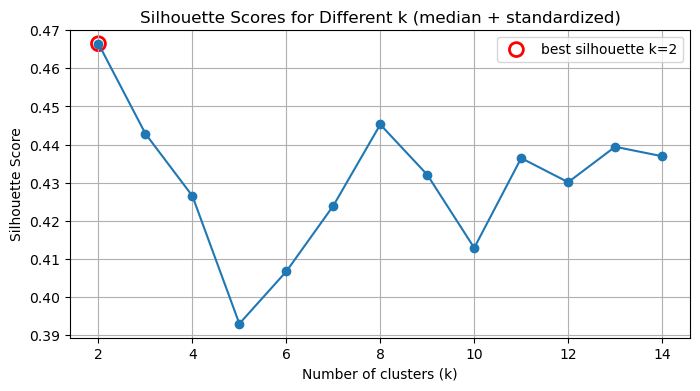

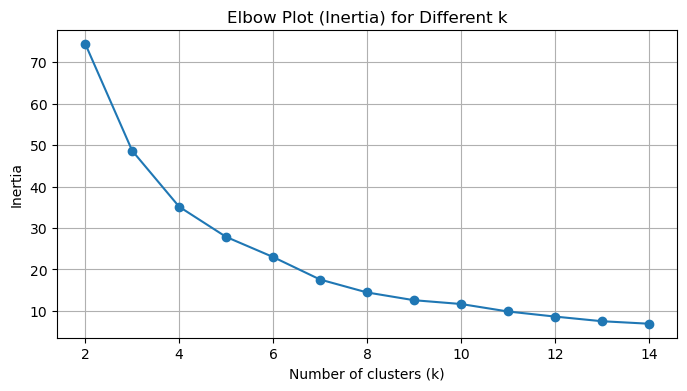


Using user-chosen k = 8 instead of silhouette-best k = 2

Cluster centroids (original units):
   cluster  median_reviews_nov  occurrence_count     score
0        0            4.204976          1.400000  4.292476
1        1            3.802775          6.875000  4.232463
2        2            3.370134          4.333333  3.640968
3        3            2.287028          6.300000  2.680778
4        4            2.171965          3.375000  2.382903
5        5            2.126241          1.166667  2.199157
6        6            1.107678          4.000000  1.357678
7        7            0.931136          1.400000  1.018636

Best-performing cluster (high median reviews & high occurrence): cluster 0
Saved detailed results to: /Users/xiuwen/Documents/GitHub/1149188/COMP647/november_subcategory_clusters.csv


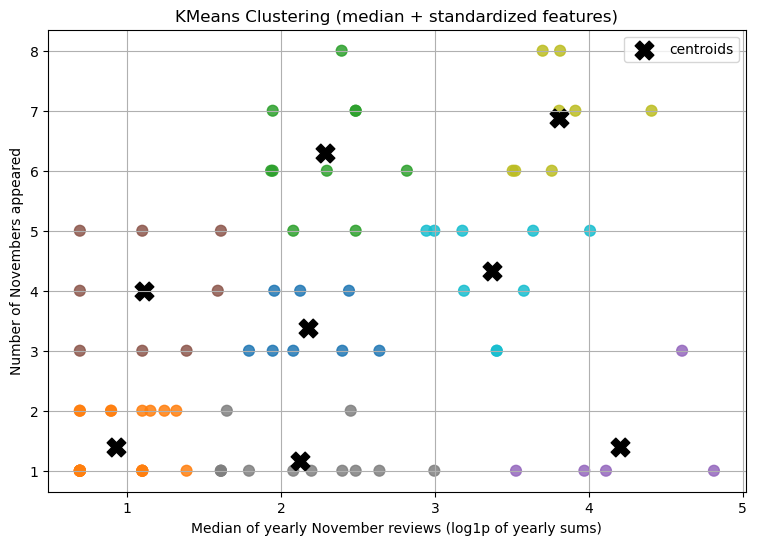


Top sub-categories in the best-performing cluster:
                    sub_category  median_reviews_nov  occurrence_count
                         Crayola            2.639057                 3
                      Soft Dolls            2.441401                 4
                Thomas & Friends            2.397895                 3
                           Chess            2.124248                 4
                      Beach Toys            2.079442                 3
Dolls' House Dolls & Accessories            1.956012                 4
                        Art Sand            1.945910                 3
             Shops & Accessories            1.791759                 3


In [125]:
nov_df = df[df['purchase_month'] == 11].copy()  # rows where purchase_month == 11
YEARS_RANGE = list(range(2001, 2017))           # 2001–2016 inclusive
TOTAL_NOVEMBER_YEARS = len(YEARS_RANGE)

# -----------------------
# 2) Compute yearly totals per sub_category (sum of reviews)
# -----------------------
grouped_yearly = (
    nov_df
    .groupby(['sub_category', 'purchase_year'])['number_of_reviews']
    .sum()
    .reset_index()
)

# -----------------------
# 3) Log1p transform yearly sums and aggregate by sub_category
# -----------------------
grouped_yearly['number_of_reviews_log'] = np.log1p(grouped_yearly['number_of_reviews'])

agg = grouped_yearly.groupby('sub_category').agg(
    median_reviews_nov=('number_of_reviews_log', 'median'),
    occurrence_count=('purchase_year', 'nunique')
).reset_index()

agg['prop_nov_years'] = agg['occurrence_count'] / TOTAL_NOVEMBER_YEARS
agg['median_reviews_nov'] = agg['median_reviews_nov'].fillna(0)

# -----------------------
# 4) Prepare feature matrix and standardize
# -----------------------
features = agg[['median_reviews_nov', 'occurrence_count']].values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# -----------------------
# 5) Evaluate different k values
# -----------------------
inertias = []
sil_scores = []
ks = range(2, 15)
RANDOM_STATE = 42

for k in ks:
    kmeans_tmp = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels_tmp = kmeans_tmp.fit_predict(features_scaled)
    inertias.append(kmeans_tmp.inertia_)
    sil_scores.append(silhouette_score(features_scaled, labels_tmp))

silhouette_results = pd.DataFrame({
    "k": list(ks),
    "Inertia": inertias,
    "Silhouette_Score": sil_scores
})

print("\n=== Silhouette and Inertia Results for KMeans (median + standardized) ===")
print(silhouette_results.to_string(index=False))

# Plot silhouette
plt.figure(figsize=(8,4))
plt.plot(ks, sil_scores, marker='o')
plt.title("Silhouette Scores for Different k (median + standardized)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
best_k_sil = int(silhouette_results.loc[silhouette_results['Silhouette_Score'].idxmax(), 'k'])
best_sil = silhouette_results['Silhouette_Score'].max()
plt.scatter([best_k_sil], [best_sil], s=100, facecolors='none', edgecolors='red', linewidths=2, label=f'best silhouette k={best_k_sil}')
plt.legend()
plt.show()

# Plot inertia (elbow)
plt.figure(figsize=(8,4))
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Plot (Inertia) for Different k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# -----------------------
# 6) Set chosen k manually (can override best silhouette k)
# -----------------------
# For example, pick a k that balances silhouette and inertia
CHOSEN_K = 8  # <--- adjust this to explore different cluster numbers
print(f"\nUsing user-chosen k = {CHOSEN_K} instead of silhouette-best k = {best_k_sil}")

# -----------------------
# 7) Fit final KMeans with chosen k
# -----------------------
kmeans = KMeans(n_clusters=CHOSEN_K, random_state=RANDOM_STATE, n_init=20)
agg['cluster'] = kmeans.fit_predict(features_scaled)
agg['median_reviews_nov_scaled'] = features_scaled[:, 0]
agg['occurrence_count_scaled'] = features_scaled[:, 1]


# 8) Convert centroids back to original space and compute cluster scores
# -----------------------
centroids_scaled = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)
centroid_df = pd.DataFrame(centroids_original, columns=['median_reviews_nov','occurrence_count'])
centroid_df['cluster'] = centroid_df.index
centroid_df['score'] = centroid_df['median_reviews_nov'] + centroid_df['occurrence_count'] / TOTAL_NOVEMBER_YEARS

# -----------------------
# 9) Re-label clusters by descending score (0 = best)
# -----------------------
centroid_df = centroid_df.sort_values('score', ascending=False).reset_index(drop=True)
centroid_df['cluster_label'] = centroid_df.index  # new human-readable labels

# Map old cluster numbers to new labels
cluster_label_map = dict(zip(centroid_df['cluster'], centroid_df['cluster_label']))
agg['cluster_label'] = agg['cluster'].map(cluster_label_map)

# Update centroid_df to use new labels
centroid_df['cluster'] = centroid_df['cluster_label']
centroid_df = centroid_df.drop(columns='cluster_label')

# Best cluster is now always 0
best_cluster = 0


# -----------------------
# 10) Save results
# -----------------------
OUTPUT_SUMMARY_CSV = "november_subcategory_clusters.csv"
agg_sorted = agg.sort_values(['cluster', 'median_reviews_nov', 'occurrence_count'], ascending=[True, False, False])
agg_sorted.to_csv(OUTPUT_SUMMARY_CSV, index=False)

print("\nCluster centroids (original units):")
print(centroid_df[['cluster','median_reviews_nov','occurrence_count','score']])
print(f"\nBest-performing cluster (high median reviews & high occurrence): cluster {best_cluster}")
print(f"Saved detailed results to: {os.path.abspath(OUTPUT_SUMMARY_CSV)}")

# -----------------------
# 11) Plot final clustering
# -----------------------
plt.figure(figsize=(9,6))
plt.scatter(agg['median_reviews_nov'], agg['occurrence_count'], c=agg['cluster'], cmap='tab10', s=60, alpha=0.85)
plt.scatter(centroid_df['median_reviews_nov'], centroid_df['occurrence_count'], c='black', s=180, marker='X', label='centroids')
plt.xlabel('Median of yearly November reviews (log1p of yearly sums)')
plt.ylabel('Number of Novembers appeared')
plt.title('KMeans Clustering (median + standardized features)')
plt.grid(True)
plt.legend()
plt.show()

# -----------------------
# 12) Print top sub-categories in best cluster
# -----------------------
best_subcats = agg[agg['cluster'] == best_cluster].sort_values('median_reviews_nov', ascending=False)
print("\nTop sub-categories in the best-performing cluster:")
print(best_subcats[['sub_category','median_reviews_nov','occurrence_count']].to_string(index=False))